In [ ]:
import os
import pandas as pd

os.chdir("/Users/uqztuong/Downloads")

samples = {
    "cancer": "01-0051_409375_T_R_22HM3TLT3_TCAGAAGGCG-GGCCATCATA_R1_merged.csv",
    "control": "20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID_97-101_Pool_3_2_merged.csv",
}

dfs = []
for samp in samples:
    df = pd.read_csv(samples[samp])
    df["sample"] = samp
    dfs.append(df)

import matplotlib.pyplot as plt

plt.figure(figsize=(2, 4))

<Figure size 200x400 with 0 Axes>

<Figure size 200x400 with 0 Axes>

In [2]:
df = pd.concat(dfs)

In [3]:
df

,AA_seq,CloneFreq,prob,high,transformed_score,sample
0,CASSLKGQPQHF,0.057554,0.999999,True,0.057554,cancer
1,CASSLKGQPQHF,0.057554,0.106939,False,0.006155,cancer
2,CASSLKGQPQHF,0.057554,0.938732,True,0.054028,cancer
3,CASHLGGNGELFF,0.041367,0.998259,True,0.041295,cancer
4,CAGDGTSGRGQETQYF,0.034173,0.805812,True,0.027537,cancer
...,...,...,...,...,...,...
2604,CASSLAEGASNEKLFF,0.000117,0.993616,True,0.000116,control
2605,CASSETGLGYEQYF,0.000117,0.940215,True,0.000110,control
2606,CASTRNTGELFF,0.000117,0.052792,False,0.000006,control
2607,CASSRRDRGPFTGNTIYF,0.000117,0.063924,False,0.000007,control


<Axes: xlabel='sample', ylabel='prob'>

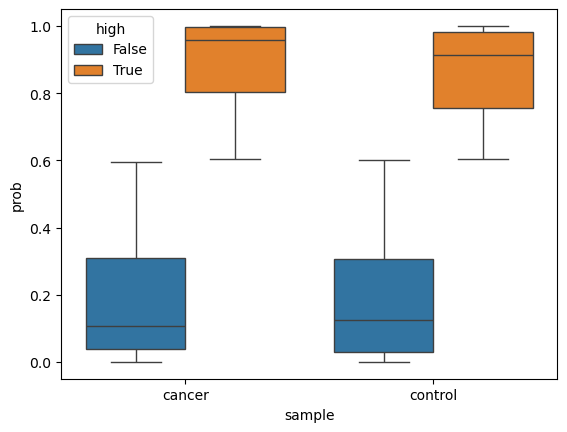

In [ ]:
import seaborn as sns

sns.boxplot(x="sample", y="prob", hue="high", data=df)

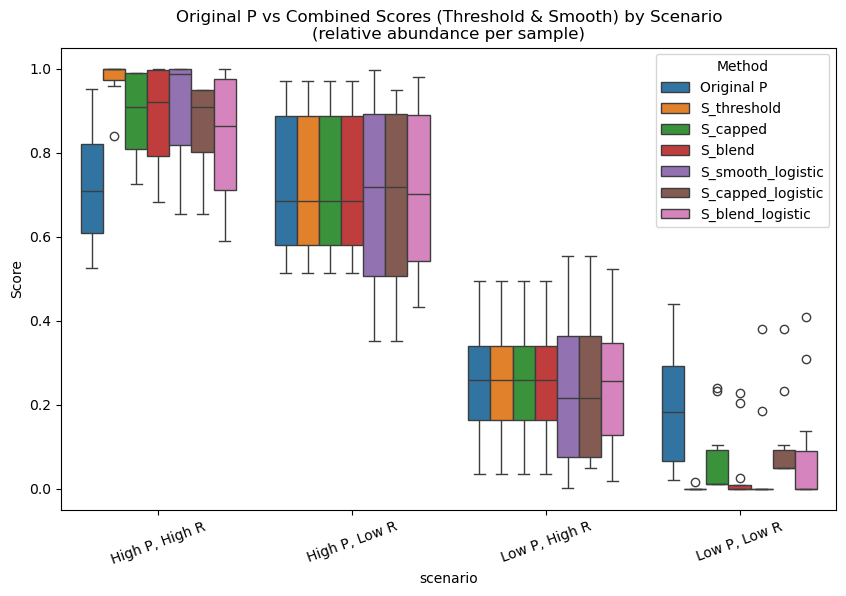

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

# from caas_jupyter_tools import display_dataframe_to_user

# --- Functions ---


def fraction_to_percentile(F_raw, eps=1e-9):
    """Convert raw abundance values to percentile ranks in [0,1] per sample."""
    n = len(F_raw)
    if n <= 1:
        return np.array([0.5])  # trivial sample
    ranks = rankdata(F_raw, method="average") - 1.0
    return ranks / max(1.0, n - 1.0)


def combined_score_sample(P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8):
    """Agreement-based threshold/min variant with relative abundance."""
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    mask_high = (P > t_P) & (R > t_R)
    A_high = np.zeros_like(P)
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    mask_low = (P < t_P) & (R < t_R)
    A_low = np.zeros_like(P)
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    S = P + alpha * A_high - beta * A_low
    return np.clip(S, 0.0, 1.0), R


def combined_score_sample_capped(
    P,
    F_raw,
    t_P=0.5,
    t_R=0.5,
    alpha=0.6,
    beta=0.8,
    delta_max=0.2,
    floor=0.01,
    ceil=0.99,
):
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    mask_high = (P > t_P) & (R > t_R)
    A_high = np.zeros_like(P)
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    mask_low = (P < t_P) & (R < t_R)
    A_low = np.zeros_like(P)
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    delta = alpha * A_high - beta * A_low
    delta = np.clip(delta, -delta_max, delta_max)

    S = P + delta
    return np.clip(S, floor, ceil), R


def combined_score_sample_blend(
    P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8, gamma=0.5
):
    """Blend original P with threshold-based adjustment."""
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    mask_high = (P > t_P) & (R > t_R)
    A_high = np.zeros_like(P)
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    mask_low = (P < t_P) & (R < t_R)
    A_low = np.zeros_like(P)
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    S_adjusted = P + alpha * A_high - beta * A_low
    S = (1 - gamma) * P + gamma * S_adjusted

    return np.clip(S, 0.0, 1.0), R


def combined_score_sample_smooth(
    P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8, k=8.0
):
    """Smooth logistic variant with relative abundance."""
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    def sig(x):
        return 1.0 / (1.0 + np.exp(-x))

    wP = sig(k * (P - t_P))
    wR = sig(k * (R - t_R))

    A_high = P * R * wP * wR
    A_low = (1 - P) * (1 - R) * (1 - wP) * (1 - wR)
    S = P + alpha * A_high - beta * A_low
    return np.clip(S, 0.0, 1.0), R


def combined_score_sample_capped_logistic(
    P,
    F_raw,
    t_P=0.5,
    t_R=0.5,
    alpha=0.6,
    beta=0.8,
    k=8.0,
    delta_max=0.2,
    floor=0.05,
    ceil=0.95,
):
    """
    Compute a capped combined score using logistic-weighted adjustments.

    Each element in P is adjusted based on its own value and the corresponding
    percentile R of the raw feature F_raw. High P & R increase the score,
    low P & R decrease it. The adjustment is smoothed with logistic weights
    instead of hard thresholds, then capped to avoid extreme changes.

    Parameters
    ----------
    P : array-like
        Original scores/probabilities in [0, 1].
    F_raw : array-like
        Raw feature values to be converted into percentiles.
    t_P : float
        Threshold for P to start contributing positively.
    t_R : float
        Threshold for R to start contributing positively.
    alpha : float
        Weight for positive adjustment (when P and R are high).
    beta : float
        Weight for negative adjustment (when P and R are low).
    k : float
        Logistic steepness controlling smoothness near thresholds.
    delta_max : float
        Maximum allowed adjustment magnitude.
    floor : float
        Minimum allowed final score.
    ceil : float
        Maximum allowed final score.

    Returns
    -------
    S : np.ndarray
        Adjusted scores, clipped to [floor, ceil].
    R : np.ndarray
        Percentile-transformed values of F_raw.
    """
    # Convert raw features to percentile scores (0 to 1)
    R = fraction_to_percentile(F_raw)

    # Logistic sigmoid function
    def sig(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Compute smooth weights for P and R based on thresholds
    wP = sig(k * (P - t_P))  # closer to 1 if P > t_P
    wR = sig(k * (R - t_R))  # closer to 1 if R > t_R

    # Positive contribution: both P and R are high
    A_high = P * R * wP * wR

    # Negative contribution: both P and R are low
    A_low = (1 - P) * (1 - R) * (1 - wP) * (1 - wR)

    # Combine positive and negative contributions with weights
    delta = alpha * A_high - beta * A_low

    # Cap the adjustment to avoid extreme changes
    delta = np.clip(delta, -delta_max, delta_max)

    # Compute final score
    S = P + delta

    # Clip final score to specified bounds
    return np.clip(S, floor, ceil), R


def combined_score_sample_blend_logistic(
    P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8, gamma=0.5, k=8.0
):
    """
    Compute a blended combined score using logistic-weighted adjustments.

    Each element in P is adjusted based on its own value and the corresponding
    percentile R of the raw feature F_raw. High P & R increase the score,
    low P & R decrease it. The adjustment is smoothed with logistic weights
    and then blended with the original P to moderate the effect.

    Parameters
    ----------
    P : array-like
        Original scores/probabilities in [0, 1].
    F_raw : array-like
        Raw feature values to be converted into percentiles.
    t_P : float
        Threshold for P to start contributing positively.
    t_R : float
        Threshold for R to start contributing positively.
    alpha : float
        Weight for positive adjustment (when P and R are high).
    beta : float
        Weight for negative adjustment (when P and R are low).
    gamma : float
        Blending factor (0 = original P, 1 = fully adjusted score).
    k : float
        Logistic steepness controlling smoothness near thresholds.

    Returns
    -------
    S : np.ndarray
        Adjusted and blended scores, clipped to [0, 1].
    R : np.ndarray
        Percentile-transformed values of F_raw.
    """
    # Convert raw features to percentile scores (0 to 1)
    R = fraction_to_percentile(F_raw)

    # Logistic sigmoid function
    def sig(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Compute smooth weights for P and R based on thresholds
    wP = sig(k * (P - t_P))
    wR = sig(k * (R - t_R))

    # Positive adjustment: high P & high R
    A_high = P * R * wP * wR

    # Negative adjustment: low P & low R
    A_low = (1 - P) * (1 - R) * (1 - wP) * (1 - wR)

    # Raw adjusted score
    S_adjusted = P + alpha * A_high - beta * A_low

    # Blend with original P to moderate adjustment
    S = (1 - gamma) * P + gamma * S_adjusted

    # Clip final score to [0,1]
    return np.clip(S, 0.0, 1.0), R


# --- Demo dataset ---

np.random.seed(42)
n_items = 50

# Generate probabilities uniformly [0,1]
P_demo = np.random.rand(n_items)

# Generate cumulative-like abundances (skewed distribution)
F_raw_demo = np.random.exponential(scale=10, size=n_items)

# Run both methods
S_thresh, R_thresh = combined_score_sample(P_demo, F_raw_demo)
S_smooth, R_smooth = combined_score_sample_smooth(P_demo, F_raw_demo)
S_capped, R_capped = combined_score_sample_capped(P_demo, F_raw_demo)
S_blend, R_blend = combined_score_sample_blend(P_demo, F_raw_demo)
S_capped_logistic, R_capped_logistic = combined_score_sample_capped_logistic(
    P_demo, F_raw_demo
)
S_blend_logistic, R_blend_logistic = combined_score_sample_blend_logistic(
    P_demo, F_raw_demo
)

# Create dataframe
df_demo = pd.DataFrame(
    {
        "P": P_demo,
        "F_raw": F_raw_demo,
        "R": R_thresh,
        "S_threshold": S_thresh,
        "S_capped": S_capped,
        "S_blend": S_blend,
        "S_smooth_logistic": S_smooth,
        "S_capped_logistic": S_capped_logistic,
        "S_blend_logistic": S_blend_logistic,
    }
)


# Categorize by scenario relative to thresholds
def categorize(p, r, t=0.5):
    if p > t and r > t:
        return "High P, High R"
    elif p > t and r <= t:
        return "High P, Low R"
    elif p <= t and r > t:
        return "Low P, High R"
    else:
        return "Low P, Low R"


df_demo["scenario"] = [categorize(p, r) for p, r in zip(df_demo["P"], df_demo["R"])]

# Display dataframe to user
# display_dataframe_to_user("Demo sample with relative abundance and combined scores", df_demo)

# --- Boxplots comparing Original P vs Combined ---

df_long = pd.melt(
    df_demo,
    id_vars=["P", "R", "F_raw", "scenario"],
    value_vars=[
        "S_threshold",
        "S_capped",
        "S_blend",
        "S_smooth_logistic",
        "S_capped_logistic",
        "S_blend_logistic",
    ],
    var_name="method",
    value_name="S",
)

# Add original P
df_P = df_demo[["P", "scenario"]].copy()
df_P["method"] = "Original P"
df_P = df_P.rename(columns={"P": "S"})
df_long = pd.concat([df_long, df_P], ignore_index=True)

scenario_order = ["High P, High R", "High P, Low R", "Low P, High R", "Low P, Low R"]
method_order = [
    "Original P",
    "S_threshold",
    "S_capped",
    "S_blend",
    "S_smooth_logistic",
    "S_capped_logistic",
    "S_blend_logistic",
]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="scenario",
    y="S",
    hue="method",
    data=df_long,
    order=scenario_order,
    hue_order=method_order,
)
plt.xticks(rotation=20)
plt.title(
    "Original P vs Combined Scores (Threshold & Smooth) by Scenario\n(relative abundance per sample)"
)
plt.ylabel("Score")
plt.legend(title="Method")
plt.show()

# --- Median shifts per scenario ---
median_shift = df_long.groupby(["scenario", "method"])["S"].median().unstack()
# display_dataframe_to_user("Median shifts per scenario", median_shift.reset_index())

In [6]:
df_demo

,P,F_raw,R,S_threshold,S_capped,S_blend,S_smooth_logistic,S_capped_logistic,S_blend_logistic,scenario
0,0.374540,34.928071,0.979592,0.374540,0.374540,0.374540,0.432181,0.432181,0.403361,"Low P, High R"
1,0.950714,14.922454,0.795918,1.000000,0.990000,1.000000,1.000000,0.950000,1.000000,"High P, High R"
2,0.731994,28.050944,0.959184,1.000000,0.931994,0.951592,1.000000,0.931994,0.909631,"High P, High R"
3,0.598658,22.521520,0.918367,0.957854,0.798658,0.778256,0.817514,0.798658,0.708086,"High P, High R"
4,0.156019,9.110544,0.571429,0.156019,0.156019,0.156019,0.059899,0.059899,0.107959,"Low P, High R"
5,0.155995,25.494354,0.938776,0.155995,0.155995,0.155995,0.159983,0.159983,0.157989,"Low P, High R"
6,0.058084,0.926555,0.122449,0.000000,0.010000,0.000000,0.000000,0.050000,0.000000,"Low P, Low R"
7,0.866176,2.181347,0.224490,0.866176,0.866176,0.866176,0.873391,0.873391,0.869783,"High P, Low R"
8,0.601115,0.462820,0.040816,0.601115,0.601115,0.601115,0.509392,0.509392,0.555253,"High P, Low R"
9,0.708073,3.935321,0.346939,0.708073,0.708073,0.708073,0.717465,0.717465,0.712769,"High P, Low R"


In [7]:
df

,AA_seq,CloneFreq,prob,high,transformed_score,sample
0,CASSLKGQPQHF,0.057554,0.999999,True,0.057554,cancer
1,CASSLKGQPQHF,0.057554,0.106939,False,0.006155,cancer
2,CASSLKGQPQHF,0.057554,0.938732,True,0.054028,cancer
3,CASHLGGNGELFF,0.041367,0.998259,True,0.041295,cancer
4,CAGDGTSGRGQETQYF,0.034173,0.805812,True,0.027537,cancer
...,...,...,...,...,...,...
2604,CASSLAEGASNEKLFF,0.000117,0.993616,True,0.000116,control
2605,CASSETGLGYEQYF,0.000117,0.940215,True,0.000110,control
2606,CASTRNTGELFF,0.000117,0.052792,False,0.000006,control
2607,CASSRRDRGPFTGNTIYF,0.000117,0.063924,False,0.000007,control


In [ ]:
dfs[0]["S_smooth_logistic"], dfs[0]["R_smooth"] = combined_score_sample_smooth(
    dfs[0]["prob"], dfs[0]["CloneFreq"]
)
dfs[1]["S_smooth_logistic"], dfs[1]["R_smooth"] = combined_score_sample_smooth(
    dfs[1]["prob"], dfs[1]["CloneFreq"]
)

In [ ]:
dfs[0]["S_smooth_capped_logistic"], dfs[0]["R_smooth_capped"] = (
    combined_score_sample_capped_logistic(dfs[0]["prob"], dfs[0]["CloneFreq"])
)
dfs[1]["S_smooth_capped_logistic"], dfs[1]["R_smooth_capped"] = (
    combined_score_sample_capped_logistic(dfs[1]["prob"], dfs[1]["CloneFreq"])
)
dfs[0]["S_smooth_blend_logistic"], dfs[0]["R_smooth_blend"] = (
    combined_score_sample_blend_logistic(dfs[0]["prob"], dfs[0]["CloneFreq"])
)
dfs[1]["S_smooth_blend_logistic"], dfs[1]["R_smooth_blend"] = (
    combined_score_sample_blend_logistic(dfs[1]["prob"], dfs[1]["CloneFreq"])
)

dfs[0]["S_smooth_capped"], dfs[0]["R_smooth_capped"] = combined_score_sample_capped(
    dfs[0]["prob"], dfs[0]["CloneFreq"]
)
dfs[1]["S_smooth_capped"], dfs[1]["R_smooth_capped"] = combined_score_sample_capped(
    dfs[1]["prob"], dfs[1]["CloneFreq"]
)
dfs[0]["S_smooth_blend"], dfs[0]["R_smooth_blend"] = combined_score_sample_blend(
    dfs[0]["prob"], dfs[0]["CloneFreq"]
)
dfs[1]["S_smooth_blend"], dfs[1]["R_smooth_blend"] = combined_score_sample_blend(
    dfs[1]["prob"], dfs[1]["CloneFreq"]
)

In [10]:
df = pd.concat(dfs)

<Axes: xlabel='sample', ylabel='prob'>

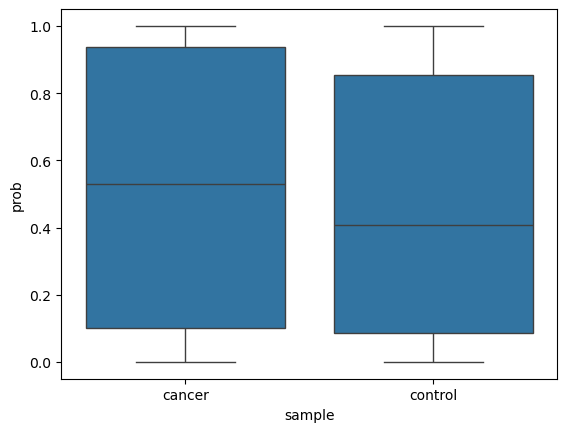

In [ ]:
sns.boxplot(x="sample", y="prob", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_logistic'>

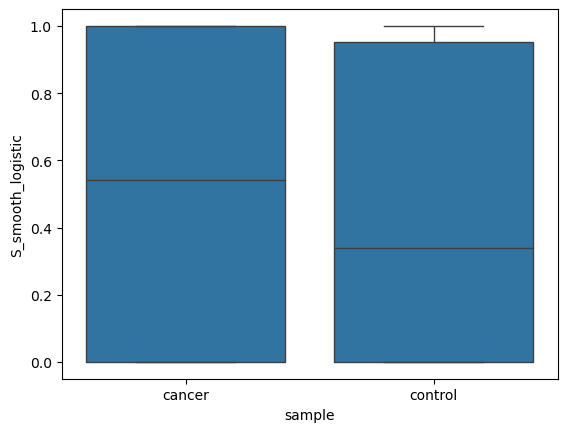

In [ ]:
sns.boxplot(x="sample", y="S_smooth_logistic", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_capped_logistic'>

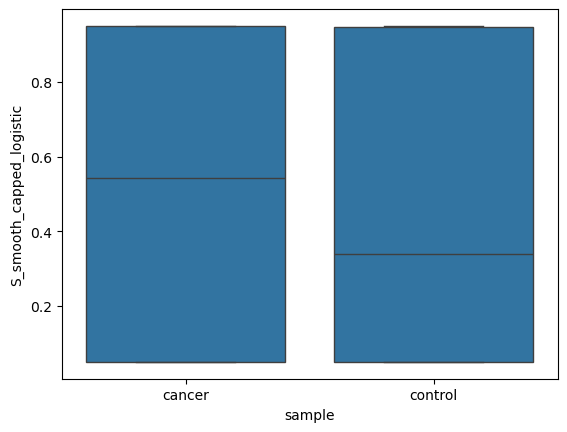

In [ ]:
sns.boxplot(x="sample", y="S_smooth_capped_logistic", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_capped'>

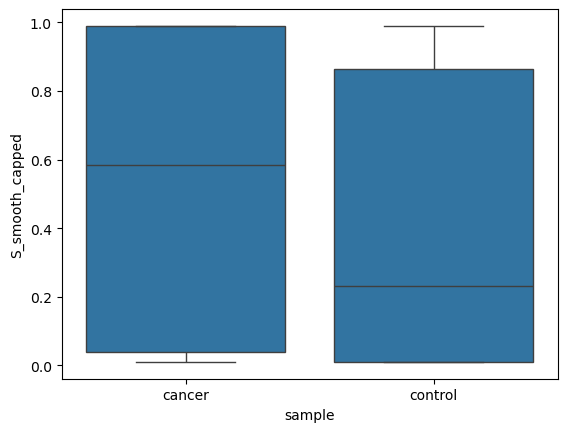

In [ ]:
sns.boxplot(x="sample", y="S_smooth_capped", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_blend'>

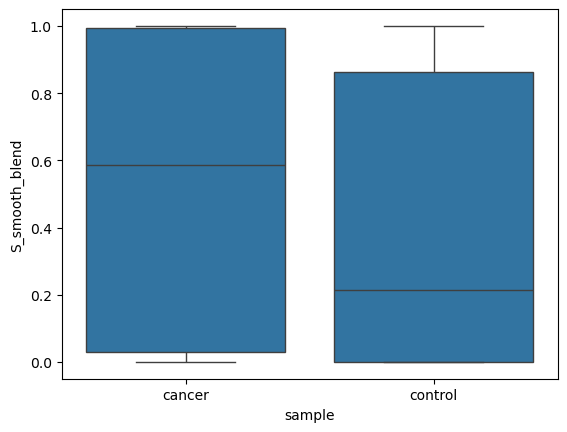

In [ ]:
sns.boxplot(x="sample", y="S_smooth_blend", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_blend_logistic'>

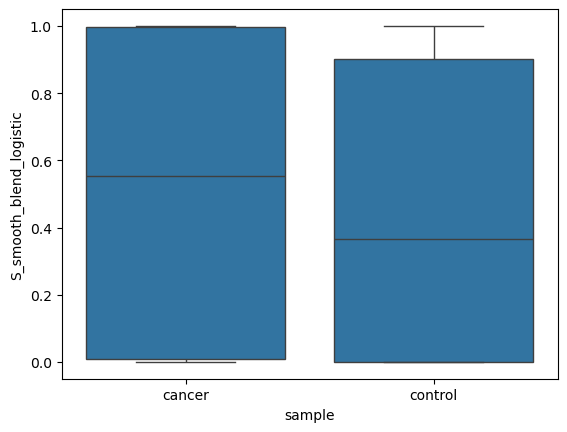

In [ ]:
sns.boxplot(x="sample", y="S_smooth_blend_logistic", data=df)

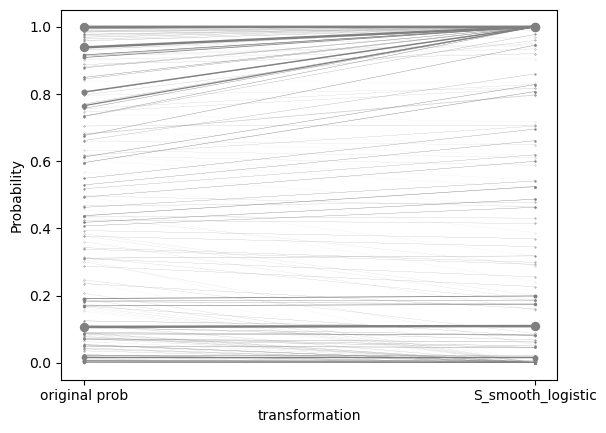

In [ ]:
var = "S_smooth_logistic"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

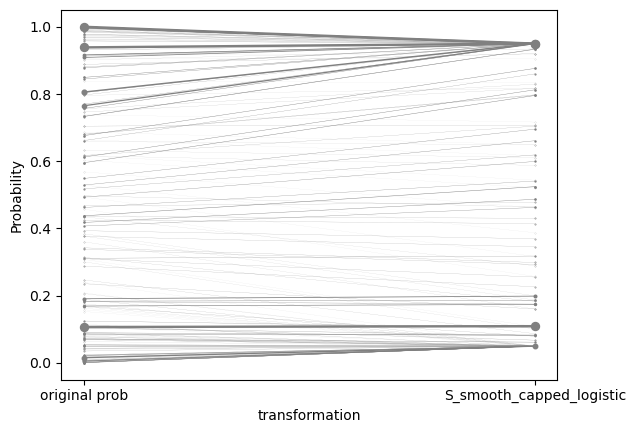

In [ ]:
var = "S_smooth_capped_logistic"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

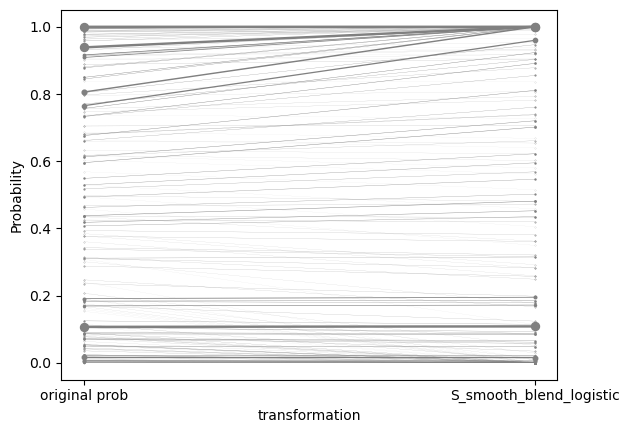

In [ ]:
var = "S_smooth_blend_logistic"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

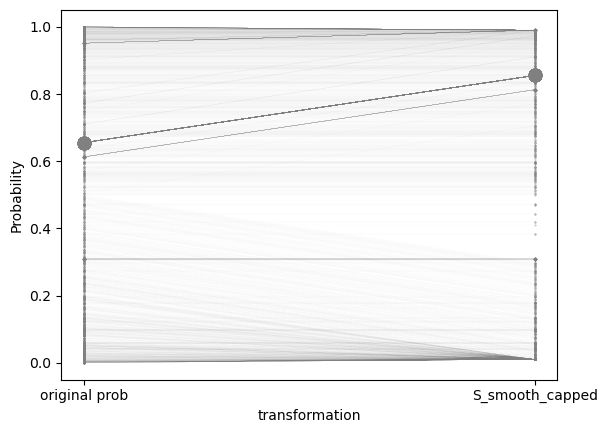

In [ ]:
var = "S_smooth_capped"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 1000  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

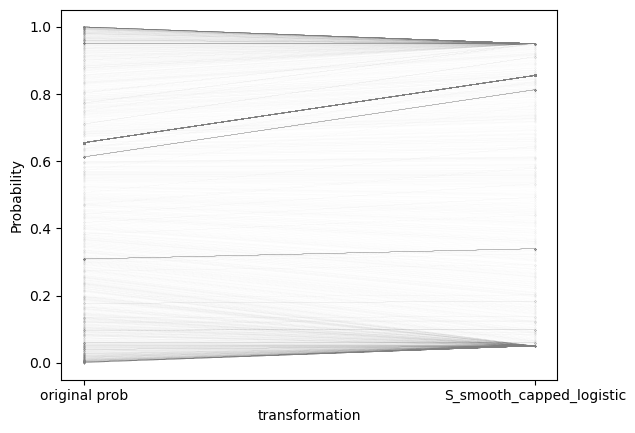

In [ ]:
var = "S_smooth_capped_logistic"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

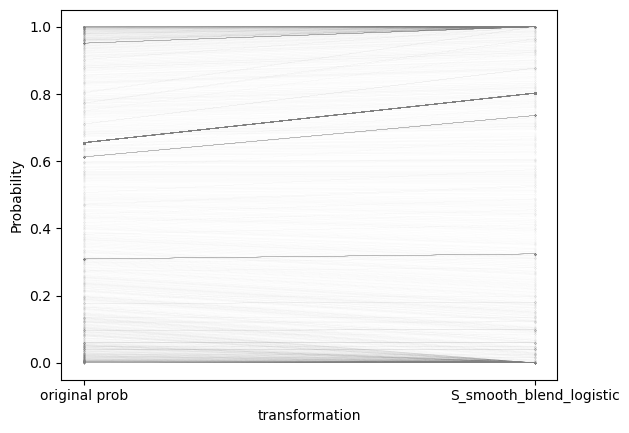

In [ ]:
var = "S_smooth_blend_logistic"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

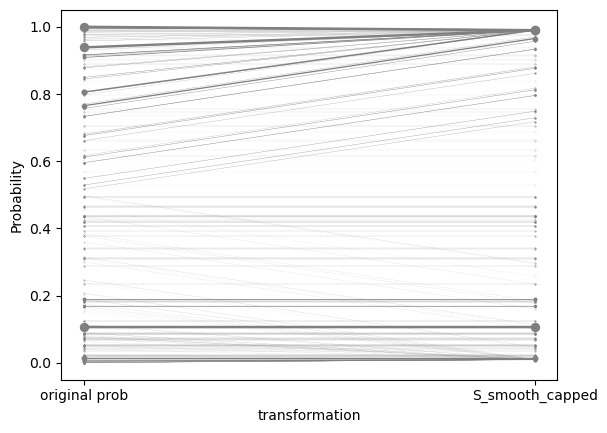

In [ ]:
var = "S_smooth_capped"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

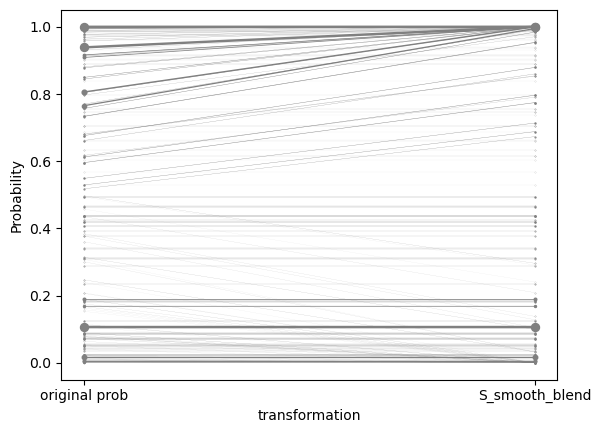

In [ ]:
var = "S_smooth_blend"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

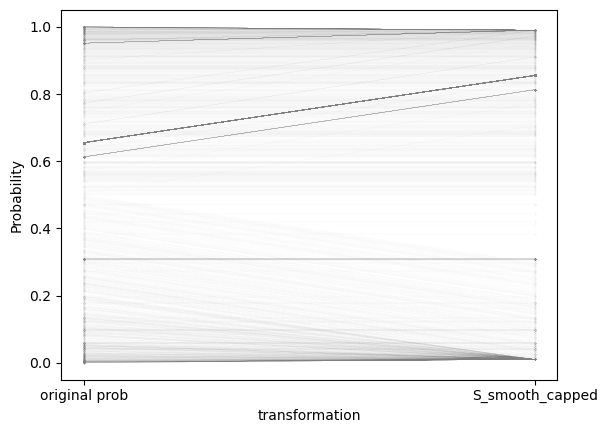

In [ ]:
var = "S_smooth_capped"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

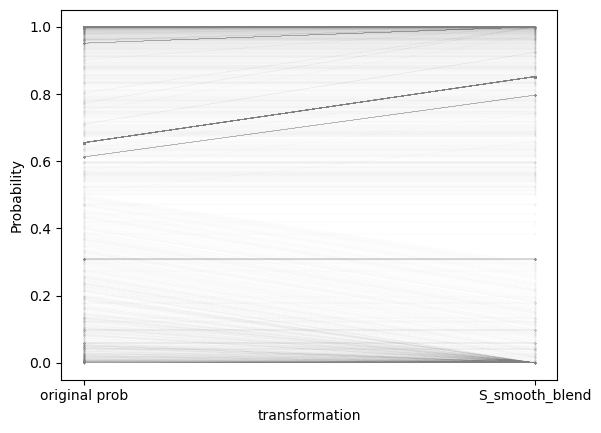

In [ ]:
var = "S_smooth_blend"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()